# Modelo de Rede U-Net com Backbone Resnet-34

Conectando ao Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Importação de bibliotecas para execução construção e visualização do modelo e do conjunto de dados

In [14]:
import tensorflow as tf
import numpy as np
import pandas as pd
import six

from random import randint

from sklearn.model_selection import train_test_split

from skimage.transform import resize
from scipy.ndimage import morphology as mp

from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

from keras import backend as K

from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.layers import concatenate
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import load_img
from tensorflow.python.keras.utils.data_utils import get_file
from tensorflow.keras.utils import get_source_inputs
from tensorflow.keras.layers import InputSpec
from tensorflow.keras.layers import Activation, SpatialDropout2D
from tensorflow.keras.layers import Input, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.layers import Conv2D, UpSampling2D, Conv2DTranspose, MaxPooling2D, Concatenate


from tqdm import tqdm_notebook

from keras import Model
from keras.utils import Sequence
from keras.saving import register_keras_serializable
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.models import load_model
from keras.optimizers import Adam
from keras import initializers
from keras import regularizers
from keras import constraints
from keras import backend as K
from keras.regularizers import l2

from keras import Model
from keras.layers import Conv2DTranspose
from keras.layers import UpSampling2D
from keras.layers import Conv2D
from keras.layers import BatchNormalization
from keras.layers import Activation
from keras.layers import Concatenate
from keras.layers import Add
from keras.layers import MaxPooling2D

import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-white')
import seaborn as sns
sns.set_style("white")

Obtêm dos arquivos armazenados no Google Drive

In [3]:
from os import listdir

image_path = '/content/drive/MyDrive/TCC/images_cut/'
labels_path = '/content/drive/MyDrive/TCC/labels_cut/'

file_names = [filename for filename in listdir(image_path)]
train_files, val_files = train_test_split(file_names, test_size=0.16, random_state=7876)

train_imgs= [image_path + i for i in train_files]
train_masks= [ labels_path + i for i in train_files]

val_imgs = [image_path + i for i in val_files]
val_masks = [labels_path + i for i in val_files]

In [ ]:
print("Training images:", len(train_imgs))
print("Validation images:", len(val_imgs))

Training images: 84
Validation images: 16


In [4]:
img_size_ori = 101
img_size_target = (224, 840)
img_w_target = 224
img_h_target = 224

def upsample(img):
    if img_size_ori == img_size_target:
        return img
    return resize(img, (img_w_target, img_h_target), mode='constant', preserve_range=True)

def downsample(img):
    return resize(img, (img_w_target, img_h_target), mode='constant', preserve_range=True)

Classe geradora de dados. Evita com que todas as imagens sejam carregas em memória durante o tempo de execução. Cada batch irá ser carregado em demanda. Referência para o padrão: https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly

São aplicados os filtros de erosão binária e dilatação binária nas máscaras. A erosão binária irá reduzir o tamanha da máscara, removendo possíveis ruídos na segmentação. O processo seguinte, de dilatação, irá aumentar novamente a máscara reduzida, tornando-a mais prevalente na imagem de verdade fundamental

Fonte: Fonte: https://www.cs.auckland.ac.nz/courses/compsci773s1c/lectures/ImageProcessing-html/topic4.htm


In [5]:
class DataGenerator(Sequence):

    def __init__(self,
                 images,
                 labels,
                 batch_size=16,
                 dim=(224,224,3),
                 shuffle=True):
        self.dim = dim
        self.images = images
        self.labels = labels
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.images) / self.batch_size))

    def __getitem__(self, index):
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        list_IDs_temp = [k for k in indexes]

        X, y = self.__data_generation(list_IDs_temp)

        return X, y

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.images))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        batch_imgs = list()
        batch_labels = list()

        for i in list_IDs_temp:
            img = load_img(self.images[i], target_size=self.dim, grayscale=False)
            img = img_to_array(img)/255
            batch_imgs.append(img)
            label = load_img(self.labels[i], target_size=self.dim, grayscale=False)
            label = img_to_array(label)[:,:,0]
            label = label != 0
            label = mp.binary_erosion(mp.binary_erosion(label))
            label = mp.binary_dilation(mp.binary_dilation(mp.binary_dilation(label)))
            label = np.expand_dims((label)*1 , axis=2)
            batch_labels.append(label)

        return np.array(batch_imgs, dtype = np.float32), np.array(batch_labels,
                                                                  dtype = np.float32)

In [6]:
def display_sample(data_tuple, img_shape):
    X,y = data_tuple
    plt.figure(figsize=(8,8))
    plt.subplot(121)
    plt.imshow(X[0])
    plt.subplot(122)
    plt.imshow(np.reshape(y[0], img_shape))

In [7]:
batch_size = 16
train_generator = DataGenerator(train_imgs, train_masks, batch_size=batch_size,
                                dim=(img_w_target,img_h_target, 3), shuffle=True)
train_steps = train_generator.__len__()

<ipython-input-5-7706036e9a64>:44: DeprecationWarning: Please use `binary_erosion` from the `scipy.ndimage` namespace, the `scipy.ndimage.morphology` namespace is deprecated.
  label = mp.binary_erosion(mp.binary_erosion(label))
<ipython-input-5-7706036e9a64>:45: DeprecationWarning: Please use `binary_dilation` from the `scipy.ndimage` namespace, the `scipy.ndimage.morphology` namespace is deprecated.
  label = mp.binary_dilation(mp.binary_dilation(mp.binary_dilation(label)))


<ipython-input-39-a700ccbf3fb6>:46: DeprecationWarning: Please use `binary_erosion` from the `scipy.ndimage` namespace, the `scipy.ndimage.morphology` namespace is deprecated.
  label = mp.binary_erosion(mp.binary_erosion(label))
<ipython-input-39-a700ccbf3fb6>:47: DeprecationWarning: Please use `binary_dilation` from the `scipy.ndimage` namespace, the `scipy.ndimage.morphology` namespace is deprecated.
  label = mp.binary_dilation(mp.binary_dilation(mp.binary_dilation(label)))


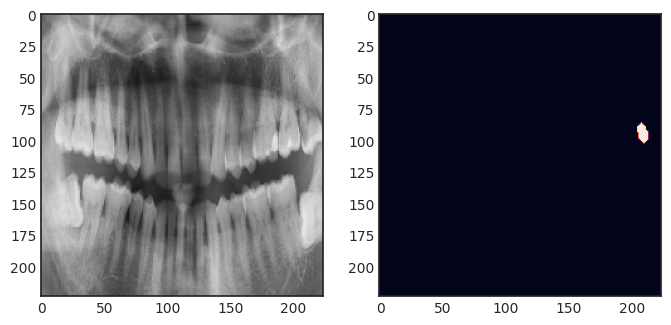

In [ ]:
display_sample(train_generator.__getitem__(3), (img_w_target,img_h_target))

In [8]:
val_generator = DataGenerator(val_imgs, val_masks, batch_size=batch_size,
                              dim=(img_w_target,img_h_target, 3), shuffle=True)
val_steps = val_generator.__len__()
val_images = val_generator.images

<ipython-input-39-a700ccbf3fb6>:46: DeprecationWarning: Please use `binary_erosion` from the `scipy.ndimage` namespace, the `scipy.ndimage.morphology` namespace is deprecated.
  label = mp.binary_erosion(mp.binary_erosion(label))
<ipython-input-39-a700ccbf3fb6>:47: DeprecationWarning: Please use `binary_dilation` from the `scipy.ndimage` namespace, the `scipy.ndimage.morphology` namespace is deprecated.
  label = mp.binary_dilation(mp.binary_dilation(mp.binary_dilation(label)))


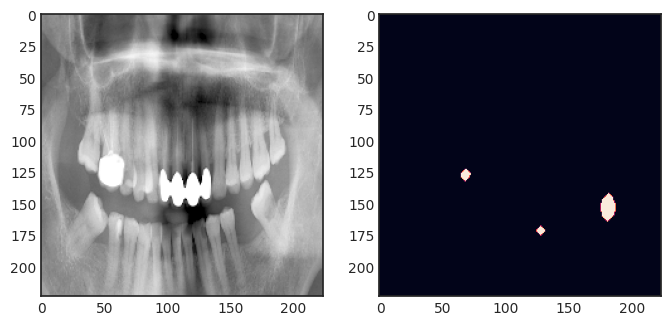

In [ ]:
display_sample(val_generator.__getitem__(0), (img_w_target, img_h_target))

### Construindo o Modelo U-Net

In [19]:
def get_block_names(stage):
    conv_name = 'decoder_stage{}_conv'.format(stage)
    bn_name = 'decoder_stage{}_bn'.format(stage)
    relu_name = 'decoder_stage{}_relu'.format(stage)
    return conv_name, bn_name, relu_name


def __unet_conv_bn_relu(stage, layer_num, **conv_params):
    filters = conv_params["filters"]
    kernel_size = conv_params["kernel_size"]
    strides = conv_params.setdefault("strides", (1, 1))
    kernel_initializer = conv_params.setdefault("kernel_initializer", "he_normal")
    padding = conv_params.setdefault("padding", "same")

    conv_name, bn_name, relu_name = get_block_names(stage)

    def f(input):
        conv = Conv2D(filters=filters, kernel_size=kernel_size,
                      strides=strides, padding=padding,
                      kernel_initializer=kernel_initializer)(input)

        norm = BatchNormalization(name=bn_name+layer_num)(conv)
        return Activation("relu", name=relu_name+layer_num)(norm)

    return f

def Upsample2D_block(filters, stage, kernel_size=(3,3), upsample_rate=(2,2),
                     skip=None):

    def layer(input_tensor):

        up_name = 'decoder_stage{}_upsample'.format(stage)

        x = UpSampling2D(size=upsample_rate, name=up_name)(input_tensor)

        if skip is not None:
            x = Concatenate()([x, skip])

        x = __unet_conv_bn_relu(
            stage,
            '1',
            filters=filters,
            kernel_size=kernel_size)(x)

        x = __unet_conv_bn_relu(
            stage,
            '2',
            filters=filters,
            kernel_size=kernel_size)(x)

        return x
    return layer

In [10]:
def get_layer_index_by_name(model, layer_name):
    """
    Gets the layer index of a model by given name
    """
    for idx, layer in enumerate(model.layers):
        if layer.name == layer_name:
            return idx

def build_unet(backbone, classes, last_block_filters, skip_layers,
               n_upsample_blocks=5, upsample_rates=(2,2,2,2,2),
               block_type='upsampling', activation='sigmoid',
               **kwargs):

    input = backbone.input
    x = backbone.output

    up_block = Upsample2D_block

    skip_layers = ([get_layer_index_by_name(backbone, l) if isinstance(l, str) else l
                    for l in skip_layers])

    for i in range(n_upsample_blocks):

        if i < len(skip_layers):
            skip = backbone.layers[skip_layers[i]].output
        else:
            skip = None

        up_size = (upsample_rates[i], upsample_rates[i])
        filters = last_block_filters * 2**(n_upsample_blocks-(i+1))

        x = up_block(filters, i, upsample_rate=up_size, skip=skip, **kwargs)(x)

    if classes < 2:
        activation = 'sigmoid'

    x = Conv2D(classes, (3,3), padding='same', name='final_conv')(x)
    x = Activation(activation, name=activation)(x)

    model = Model(input, x)

    return model

In [11]:
def _bn_relu(input):
    norm = BatchNormalization(axis=CHANNEL_AXIS)(input)
    return Activation("relu")(norm)


def _conv_bn_relu(**conv_params):
    filters = conv_params["filters"]
    kernel_size = conv_params["kernel_size"]
    strides = conv_params.setdefault("strides", (1, 1))
    kernel_initializer = conv_params.setdefault("kernel_initializer", "he_normal")
    padding = conv_params.setdefault("padding", "same")
    kernel_regularizer = conv_params.setdefault("kernel_regularizer", l2(1.e-4))

    def f(input):
        conv = Conv2D(filters=filters, kernel_size=kernel_size,
                      strides=strides, padding=padding,
                      kernel_initializer=kernel_initializer,
                      kernel_regularizer=kernel_regularizer)(input)
        return _bn_relu(conv)

    return f


def _bn_relu_conv(**conv_params):
    filters = conv_params["filters"]
    kernel_size = conv_params["kernel_size"]
    strides = conv_params.setdefault("strides", (1, 1))
    kernel_initializer = conv_params.setdefault("kernel_initializer", "he_normal")
    padding = conv_params.setdefault("padding", "same")
    kernel_regularizer = conv_params.setdefault("kernel_regularizer", l2(1.e-4))

    def f(input):
        activation = _bn_relu(input)
        return Conv2D(filters=filters, kernel_size=kernel_size,
                      strides=strides, padding=padding,
                      kernel_initializer=kernel_initializer,
                      kernel_regularizer=kernel_regularizer)(activation)

    return f


def _shortcut(input, residual):
    input_shape = K.int_shape(input)
    residual_shape = K.int_shape(residual)
    stride_width = int(round(input_shape[ROW_AXIS] / residual_shape[ROW_AXIS]))
    stride_height = int(round(input_shape[COL_AXIS] / residual_shape[COL_AXIS]))
    equal_channels = input_shape[CHANNEL_AXIS] == residual_shape[CHANNEL_AXIS]

    shortcut = input
    if stride_width > 1 or stride_height > 1 or not equal_channels:
        shortcut = Conv2D(filters=residual_shape[CHANNEL_AXIS],
                          kernel_size=(1, 1),
                          strides=(stride_width, stride_height),
                          padding="valid",
                          kernel_initializer="he_normal",
                          kernel_regularizer=l2(0.0001))(input)

    return Add()([shortcut, residual])

def base_block(filters, init_strides=(1, 1), is_first_block_of_first_layer=False):
    def f(input):

        if is_first_block_of_first_layer:
            conv1 = Conv2D(filters=filters, kernel_size=(3, 3),
                           strides=init_strides,
                           padding="same",
                           kernel_initializer="he_normal",
                           kernel_regularizer=l2(1e-4))(input)
        else:
            conv1 = _bn_relu_conv(filters=filters, kernel_size=(3, 3),
                                  strides=init_strides)(input)

        residual = _bn_relu_conv(filters=filters, kernel_size=(3, 3))(conv1)
        return _shortcut(input, residual)

    return f

def _residual_block(block_function, filters, repetitions, is_first_layer=False):
    def f(input):
        for i in range(repetitions):
            init_strides = (1, 1)
            if i == 0 and not is_first_layer:
                init_strides = (2, 2)
            input = block_function(filters=filters, init_strides=init_strides,
                                   is_first_block_of_first_layer=(is_first_layer and i == 0))(input)
        return input

    return f

def _handle_dim_ordering():
    global ROW_AXIS
    global COL_AXIS
    global CHANNEL_AXIS
    ROW_AXIS = 1
    COL_AXIS = 2
    CHANNEL_AXIS = 3

def _get_block(identifier):
    if isinstance(identifier, six.string_types):
        res = globals().get(identifier)
        if not res:
            raise ValueError('Invalid {}'.format(identifier))
        return res
    return identifier


class Resnet34Builder(object):
    @staticmethod
    def build(input_shape, block_fn, repetitions,input_tensor):
        _handle_dim_ordering()
        if len(input_shape) != 3:
            raise Exception("Input shape should be a tuple (nb_channels, nb_rows, nb_cols)")

        input_shape = (input_shape[1], input_shape[2], input_shape[0])

        block_fn = _get_block(block_fn)

        if input_tensor is None:
            img_input = Input(shape=input_shape)
        else:
            if not K.is_keras_tensor(input_tensor):
                img_input = Input(tensor=input_tensor, shape=input_shape)
            else:
                img_input = input_tensor

        conv1 = _conv_bn_relu(filters=64, kernel_size=(7, 7), strides=(2, 2))(img_input)
        pool1 = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding="same")(conv1)

        block = pool1
        filters = 64
        for i, r in enumerate(repetitions):
            block = _residual_block(block_fn, filters=filters, repetitions=r,
                                    is_first_layer=(i == 0))(block)
            filters *= 2

        # Last activation
        block = _bn_relu(block)

        model = Model(inputs=img_input, outputs=block)
        return model

    @staticmethod
    def build_resnet_34(input_shape,input_tensor):
        return Resnet34Builder.build(input_shape, base_block, [3, 4, 6, 3],input_tensor)

In [12]:
def UResNet34(input_shape=(None, None, 3), classes=1, decoder_filters=16,
              decoder_block_type='upsampling', encoder_weights=None,
              input_tensor=None, activation='sigmoid', **kwargs):

    backbone = Resnet34Builder.build_resnet_34(
        input_shape=input_shape,
        input_tensor=input_tensor)

    skip_connections = list([97,54,25])
    model = build_unet(backbone, classes, decoder_filters,
                       skip_connections, block_type=decoder_block_type,
                       activation=activation, **kwargs)

    return model

In [17]:
model = UResNet34(input_shape=(3,224,224))

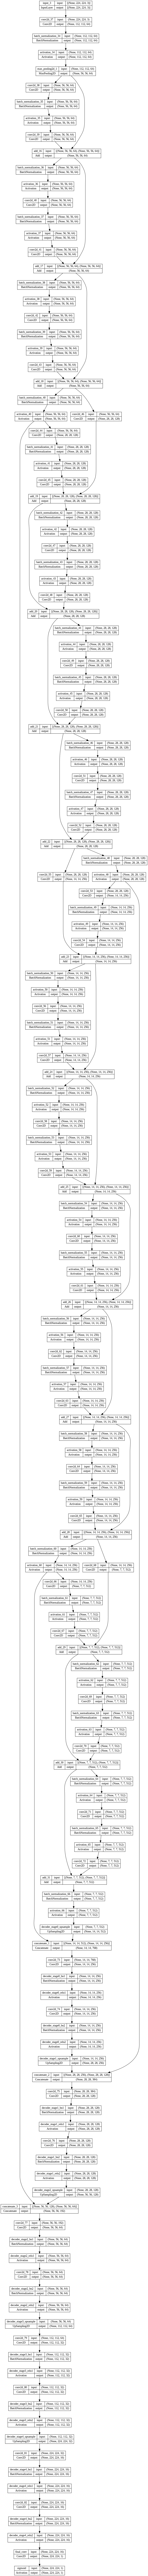

In [18]:
from keras.utils import plot_model

plot_model(model, show_shapes=True)

## Model Compiling and Fitting

In [ ]:
from keras.losses import binary_crossentropy, BinaryCrossentropy

alpha = 0.25
gamma = 2

@register_keras_serializable(package="unetResnet34", name="jaccard_index")
def jaccard_index(y_true, y_pred):
    # https://en.wikipedia.org/wiki/Jaccard_index
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)

    intersection = K.sum(y_true_f * y_pred_f)
    union = K.sum((y_true_f + y_pred_f) - (y_true_f * y_pred_f))
    return 1 - (intersection / union)

@register_keras_serializable(package="unetResnet34", name="dice_coef")
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred = K.cast(y_pred, 'float32')
    y_pred_f = K.cast(K.greater(K.flatten(y_pred), 0.5), 'float32')
    intersection = y_true_f * y_pred_f
    score = 2. * K.sum(intersection) / (K.sum(y_true_f) + K.sum(y_pred_f))
    return score

@register_keras_serializable(package="unetResnet34", name="generalized_dice_coefficient")
def generalized_dice_coefficient(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (
            K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return score

@register_keras_serializable(package="unetResnet34", name="dice_loss")
def dice_loss(y_true, y_pred):
    loss = 1 - generalized_dice_coefficient(y_true, y_pred)
    return loss

@register_keras_serializable(package="unetResnet34", name="soft_dice")
def soft_dice(y_true, y_pred, axis=(0, 1, 2), epsilon=0.00001):
    dice_numerator = (2 * K.sum(y_pred * y_true, axis = axis)) + epsilon
    dice_denominator = K.sum(y_pred * y_pred, axis = axis) + K.sum(y_true * y_true,
                                                                   axis=axis) + epsilon
    softDice_loss = 1 - K.mean(dice_numerator/dice_denominator)
    return softDice_loss

@register_keras_serializable(package="unetResnet34", name="bce_softDice_loss")
def bce_softDice_loss(y_true, y_pred):
    w1 = 0.6
    w2 = 0.4
    loss = w1 * binary_crossentropy(y_true, y_pred) + w2 * soft_dice(y_true,y_pred)
    return loss

@register_keras_serializable(package="unetResnet34", name="log_cosh_dice_loss")
def log_cosh_dice_loss(y_true, y_pred):
    x = dice_loss(y_true, y_pred)
    return tf.math.log((tf.exp(x) + tf.exp(-x)) / 2.0)

@register_keras_serializable(package="unetResnet34", name="bce_dice_loss")
def bce_dice_loss(y_true, y_pred):
    return (binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)) / 2.0

@register_keras_serializable(package="unetResnet34", name="focal_loss_with_logits")
def focal_loss_with_logits(logits, targets, alpha, gamma, y_pred):
    weight_a = alpha * (1 - y_pred) ** gamma * targets
    weight_b = (1 - alpha) * y_pred ** gamma * (1 - targets)

    return (tf.math.log1p(tf.exp(-tf.abs(logits))) + tf.nn.relu(
        -logits)) * (weight_a + weight_b) + logits * weight_b

@register_keras_serializable(package="unetResnet34", name="focal_loss")
def focal_loss(y_true, y_pred):
    y_pred = tf.clip_by_value(y_pred, tf.keras.backend.epsilon(),
                              1 - tf.keras.backend.epsilon())
    logits = tf.math.log(y_pred / (1 - y_pred))
    loss = focal_loss_with_logits(logits=logits, targets=y_true,
                                       alpha=alpha, gamma=gamma, y_pred=y_pred)
    return tf.reduce_mean(loss)

@register_keras_serializable(package="unetResnet34", name="tversky_index")
def tversky_index(y_true, y_pred):
    smooth = 1
    y_true_pos = K.flatten(y_true)
    y_pred_pos = K.flatten(y_pred)
    true_pos = K.sum(y_true_pos * y_pred_pos)
    false_neg = K.sum(y_true_pos * (1 - y_pred_pos))
    false_pos = K.sum((1 - y_true_pos) * y_pred_pos)
    alpha = 0.7
    return (true_pos + smooth) / (true_pos + alpha * false_neg + (
                1 - alpha) * false_pos + smooth)

@register_keras_serializable(package="unetResnet34", name="tversky_loss")
def tversky_loss(y_true, y_pred):
    return 1 - tversky_index(y_true, y_pred)

@register_keras_serializable(package="unetResnet34", name="focal_tversky")
def focal_tversky(y_true, y_pred):
    pt_1 = tversky_index(y_true, y_pred)
    gamma = 0.75
    return K.pow((1 - pt_1), gamma)

@register_keras_serializable(package="unetResnet34", name="ssim_loss")
def ssim_loss(y_true, y_pred):
    """
    Structural Similarity Index (SSIM) loss
    """
    return 1 - tf.image.ssim(y_true, y_pred, max_val=1)

@register_keras_serializable(package="unetResnet34", name="basnet_hybrid_loss")
def basnet_hybrid_loss(y_true, y_pred):
    """
    Hybrid loss proposed in BASNET (https://arxiv.org/pdf/2101.04704.pdf)
    The hybrid loss is a combination of the binary cross entropy, structural similarity
    and intersection-over-union losses, which guide the network to learn
    three-level (i.e., pixel-, patch- and map- level) hierarchy representations.
    """
    bce_loss = BinaryCrossentropy(from_logits=False)
    bce_loss = bce_loss(y_true, y_pred)

    ms_ssim_loss = (y_true, y_pred)
    j_loss = jaccard_index(y_true, y_pred)

    return bce_loss + ms_ssim_loss + j_loss

@register_keras_serializable(package="unetResnet34", name="unet3p_hybrid_loss")
def unet3p_hybrid_loss(y_true, y_pred):
    """
    Hybrid loss proposed in UNET 3+ (https://arxiv.org/ftp/arxiv/papers/2004/2004.08790.pdf)
    Hybrid loss for segmentation in three-level hierarchy – pixel, patch and map-level,
    which is able to capture both large-scale and fine structures with clear boundaries.
    """
    f_loss = focal_loss(y_true, y_pred)
    ms_ssim_loss = ssim_loss(y_true, y_pred)
    j_loss = jaccard_index(y_true, y_pred)

    return f_loss + ms_ssim_loss + j_loss

@register_keras_serializable(package="unetResnet34", name="get_iou_vector")
def get_iou_vector(A, B):
    batch_size = A.shape[0]
    metric = []
    for batch in range(batch_size):
        t, p = A[batch]>0, B[batch]>0
        intersection = np.logical_and(t, p)
        union = np.logical_or(t, p)
        iou = (np.sum(intersection > 0) + 1e-10 )/ (np.sum(union > 0) + 1e-10)
        thresholds = np.arange(0.5, 1, 0.05)
        s = []
        for thresh in thresholds:
            s.append(iou > thresh)
        metric.append(np.mean(s))

    return np.mean(metric)

@register_keras_serializable(package="unetResnet34", name="iou_metric")
def iou_metric(label, pred):
    return tf.py_function(get_iou_vector, [label, pred>0.5], np.float32)


In [ ]:
from keras.optimizers import Adam

model.compile(optimizer='adam', loss=bce_softDice_loss, metrics = ['accuracy', tf.keras.metrics.MeanIoU(num_classes=2)])
mc = ModelCheckpoint(mode='max', filepath='/content/drive/MyDrive/TCC/top.model.keras',
                     save_best_only='True', save_weights_only='True', verbose=1)
callbacks = [mc]
model.metrics_names

[]

In [ ]:
model_history =  model.fit(train_generator, steps_per_epoch=train_steps,epochs=100,
                           validation_data=val_generator,validation_steps=val_steps)

<ipython-input-39-a700ccbf3fb6>:46: DeprecationWarning: Please use `binary_erosion` from the `scipy.ndimage` namespace, the `scipy.ndimage.morphology` namespace is deprecated.
  label = mp.binary_erosion(mp.binary_erosion(label))
<ipython-input-39-a700ccbf3fb6>:47: DeprecationWarning: Please use `binary_dilation` from the `scipy.ndimage` namespace, the `scipy.ndimage.morphology` namespace is deprecated.
  label = mp.binary_dilation(mp.binary_dilation(mp.binary_dilation(label)))


Epoch 1/100
5/5 [==============================] - 27s 1s/step - loss: 2.0831 - accuracy: 0.9716 - mean_io_u_3: 0.4980 - val_loss: 1.8408 - val_accuracy: 0.9962 - val_mean_io_u_3: 0.4981
Epoch 2/100
5/5 [==============================] - 4s 877ms/step - loss: 1.7253 - accuracy: 0.9959 - mean_io_u_3: 0.4980 - val_loss: 1.6007 - val_accuracy: 0.9962 - val_mean_io_u_3: 0.4981
Epoch 3/100
5/5 [==============================] - 4s 879ms/step - loss: 1.4453 - accuracy: 0.9962 - mean_io_u_3: 0.4981 - val_loss: 1.3913 - val_accuracy: 0.9962 - val_mean_io_u_3: 0.4981
Epoch 4/100
5/5 [==============================] - 4s 870ms/step - loss: 1.2160 - accuracy: 0.9961 - mean_io_u_3: 0.4980 - val_loss: 1.2485 - val_accuracy: 0.9962 - val_mean_io_u_3: 0.4981
Epoch 5/100
5/5 [==============================] - 4s 865ms/step - loss: 1.0393 - accuracy: 0.9960 - mean_io_u_3: 0.4980 - val_loss: 1.0406 - val_accuracy: 0.9962 - val_mean_io_u_3: 0.4981
Epoch 6/100
5/5 [==============================] - 4s 865

In [ ]:
model_history.history.keys()

dict_keys(['loss', 'accuracy', 'mean_io_u_3', 'val_loss', 'val_accuracy', 'val_mean_io_u_3'])

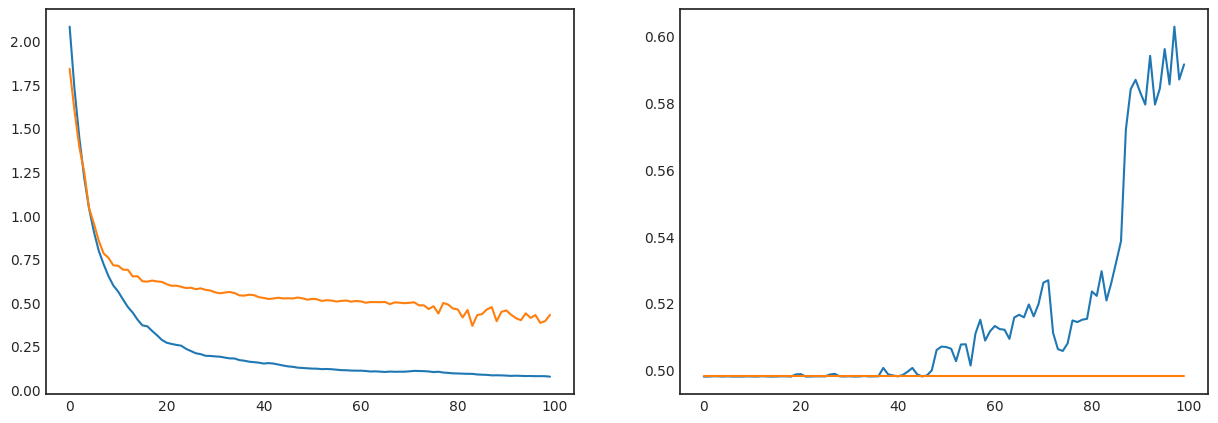

In [ ]:
fig, (ax_loss, ax_iou) = plt.subplots(1, 2, figsize=(15,5))
ax_loss.plot(model_history.epoch, model_history.history["loss"], label="Train loss")
ax_loss.plot(model_history.epoch, model_history.history["val_loss"], label="Validation loss")
# ax_acc.plot(model_history.epoch, model_history.history["accuracy"], label="Train accuracy")
# ax_acc.plot(model_history.epoch, model_history.history["val_accuracy"], label="Validation accuracy")
ax_iou.plot(model_history.epoch, model_history.history["mean_io_u_3"], label="Train Iou")
ax_iou.plot(model_history.epoch, model_history.history["val_mean_io_u_3"], label="Validation Iou")

In [ ]:
def make_prediction(model,image,shape):
    img = img_to_array(load_img(image,target_size=shape))
    img = np.expand_dims(img,axis=0)/255.
    mask = model.predict(img)

    return mask

In [ ]:
def overlay_mask(image, mask, color=(255, 0, 0), alpha=0.5):
    """
    Overlay a mask on an image.

    Args:
        image: The image to overlay the mask on.
        mask: The mask to overlay.
        color: The color of the mask.
        alpha: The transparency of the mask.

    Returns:
        The image with the mask overlayed.
    """
    print(type(mask))
    mask = np.where(mask > 0.5, 1, 0)

    image_with_mask = image.copy()

    image_with_mask[mask == 1] = image_with_mask[mask == 1] * alpha

    return image_with_mask


(224, 224, 3)
818.png
1/1 [==============================] - 1s 764ms/step
<class 'numpy.ndarray'>
(224, 224, 3)
740.png
1/1 [==============================] - 0s 33ms/step
<class 'numpy.ndarray'>
(224, 224, 3)
1091.png
1/1 [==============================] - 0s 32ms/step
<class 'numpy.ndarray'>
(224, 224, 3)
759.png
1/1 [==============================] - 0s 31ms/step
<class 'numpy.ndarray'>
(224, 224, 3)
939.png
1/1 [==============================] - 0s 27ms/step
<class 'numpy.ndarray'>
(224, 224, 3)
369.png
1/1 [==============================] - 0s 29ms/step
<class 'numpy.ndarray'>
(224, 224, 3)
963.png
1/1 [==============================] - 0s 29ms/step


<ipython-input-59-8f44a1126520>:30: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(8,8))


<class 'numpy.ndarray'>
(224, 224, 3)
370.png
1/1 [==============================] - 0s 27ms/step
<class 'numpy.ndarray'>
(224, 224, 3)
952.png
1/1 [==============================] - 0s 30ms/step
<class 'numpy.ndarray'>
(224, 224, 3)
1016.png
1/1 [==============================] - 0s 29ms/step
<class 'numpy.ndarray'>
(224, 224, 3)
1067.png
1/1 [==============================] - 0s 31ms/step
<class 'numpy.ndarray'>
(224, 224, 3)
1042.png
1/1 [==============================] - 0s 26ms/step
<class 'numpy.ndarray'>
(224, 224, 3)
1018.png
1/1 [==============================] - 0s 31ms/step
<class 'numpy.ndarray'>
(224, 224, 3)
925.png
1/1 [==============================] - 0s 30ms/step
<class 'numpy.ndarray'>
(224, 224, 3)
1074.png
1/1 [==============================] - 0s 27ms/step
<class 'numpy.ndarray'>
(224, 224, 3)
857.png
1/1 [==============================] - 0s 26ms/step
<class 'numpy.ndarray'>


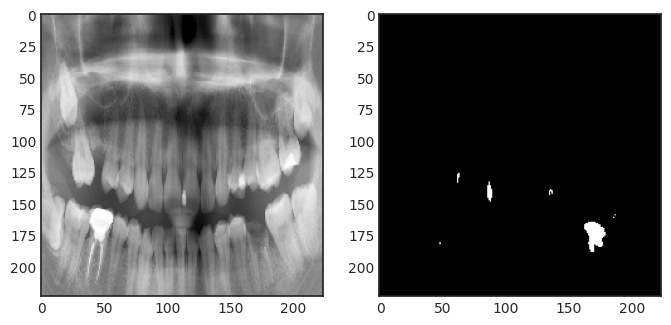

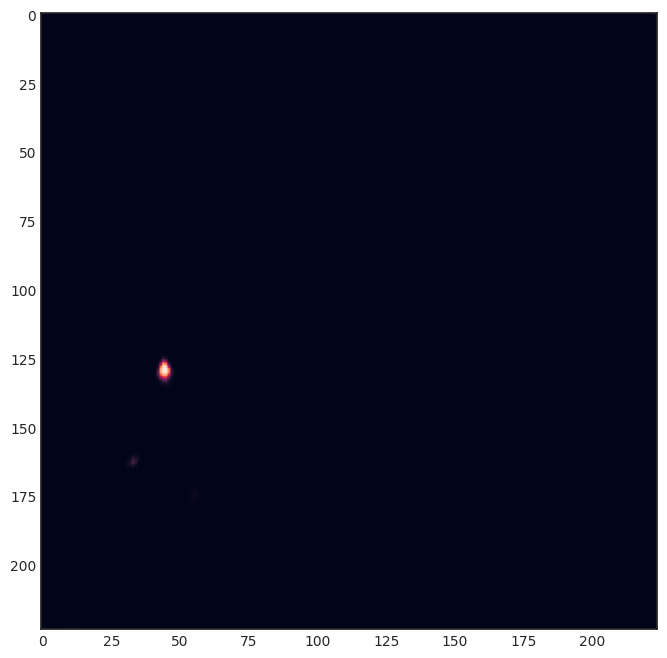

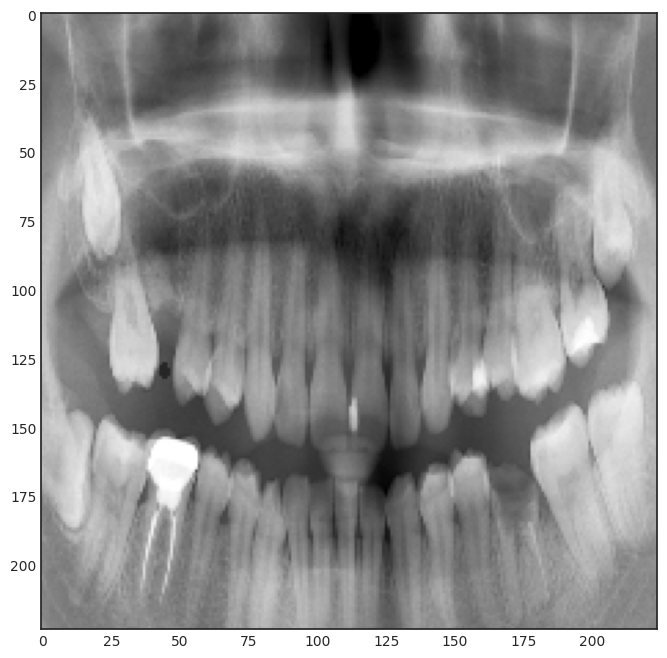

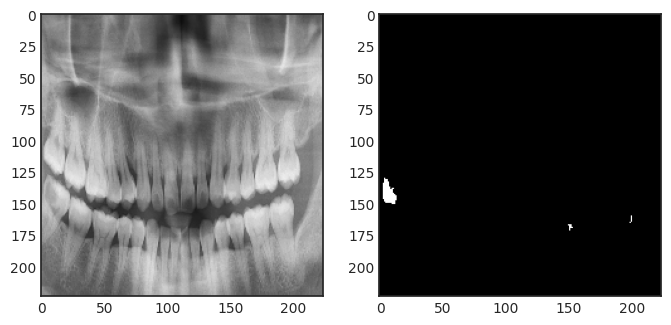

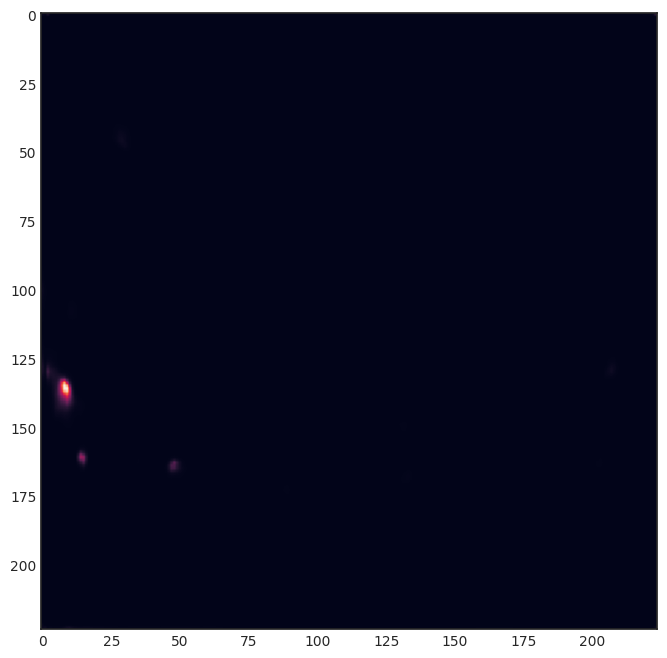

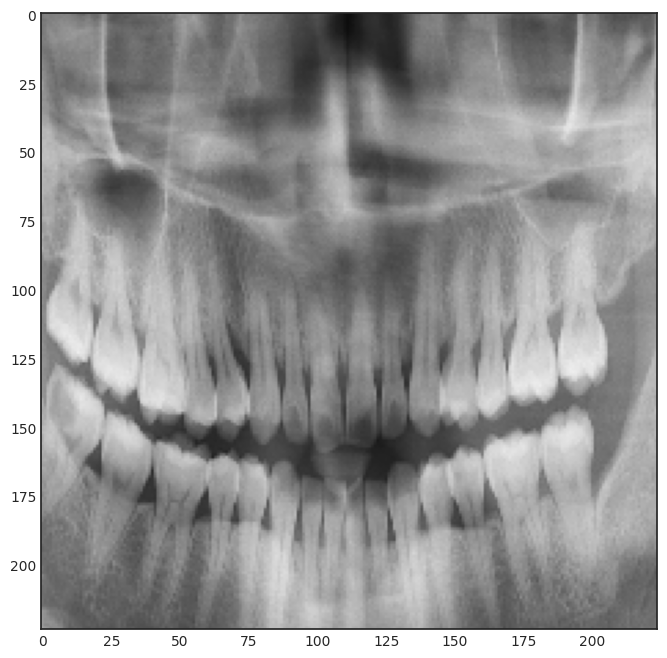

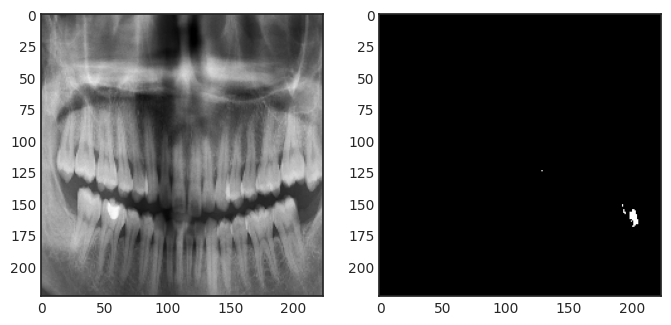

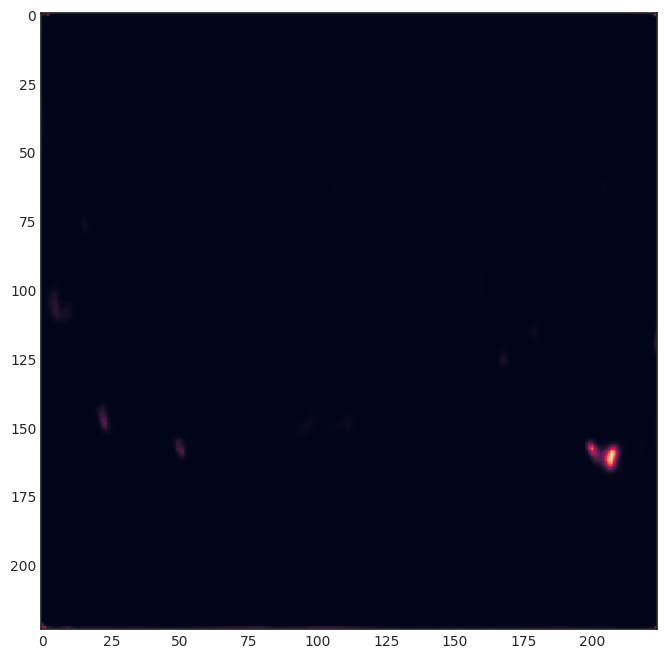

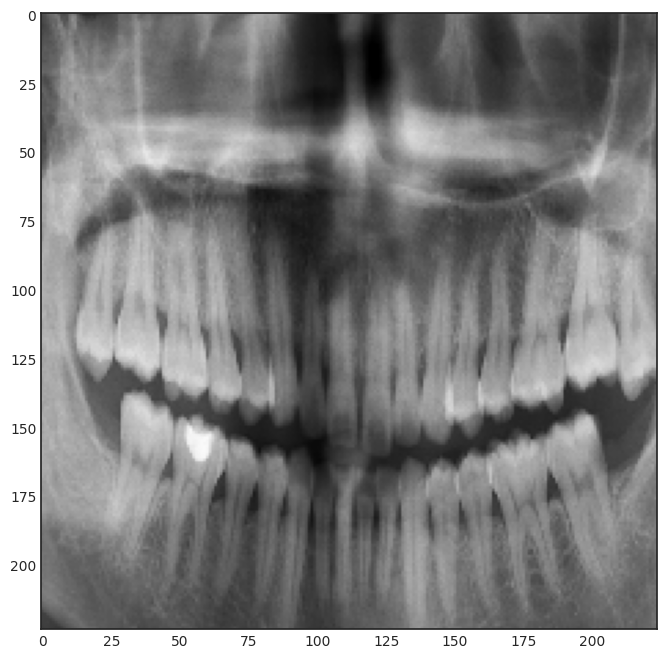

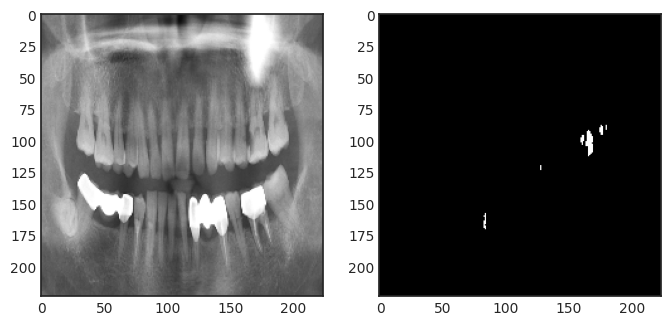

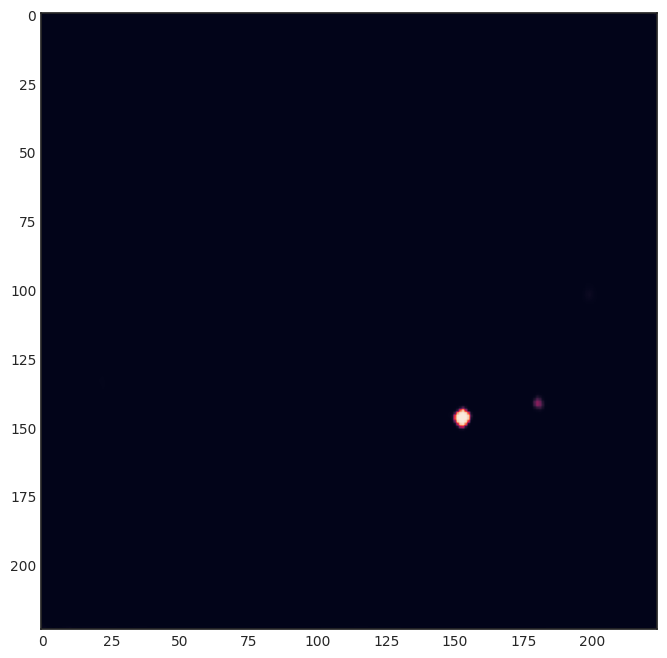

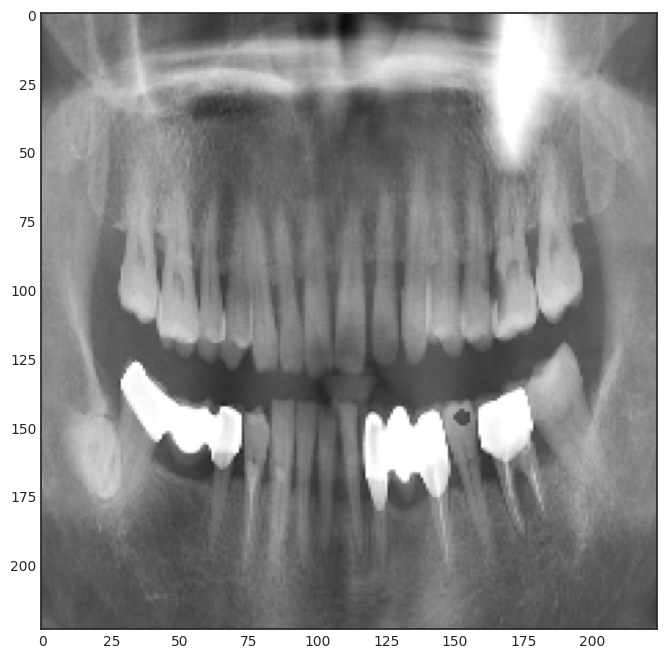

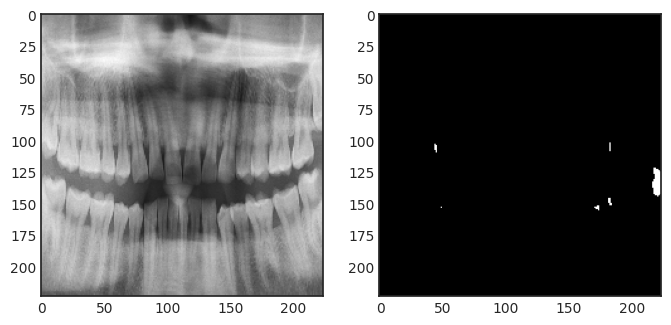

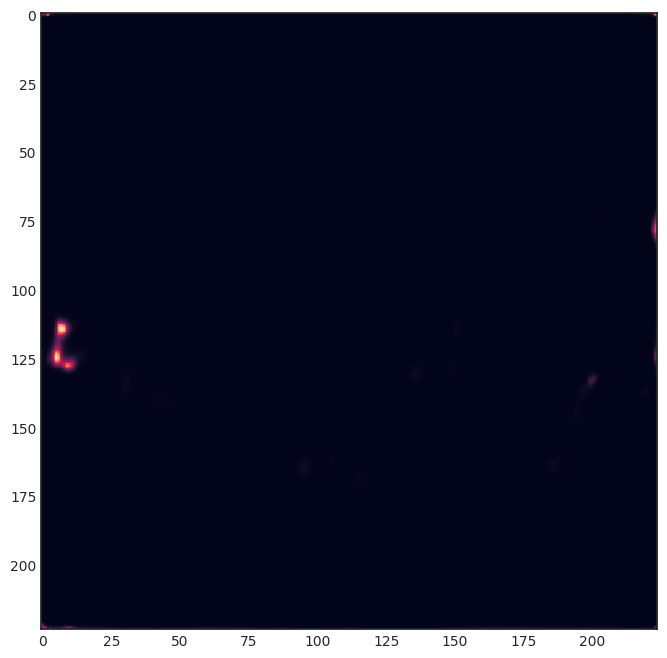

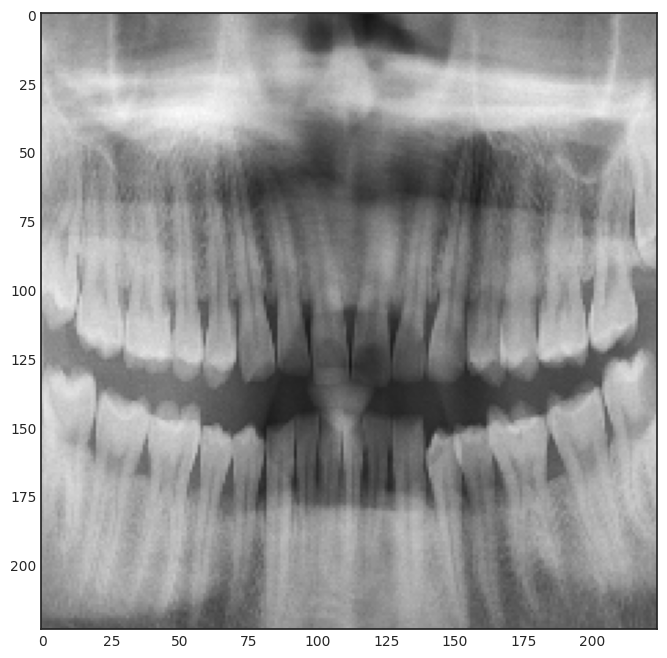

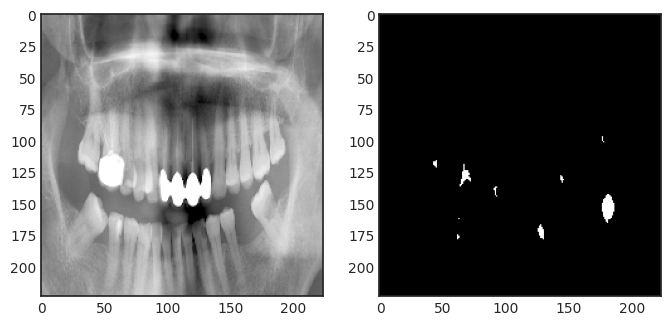

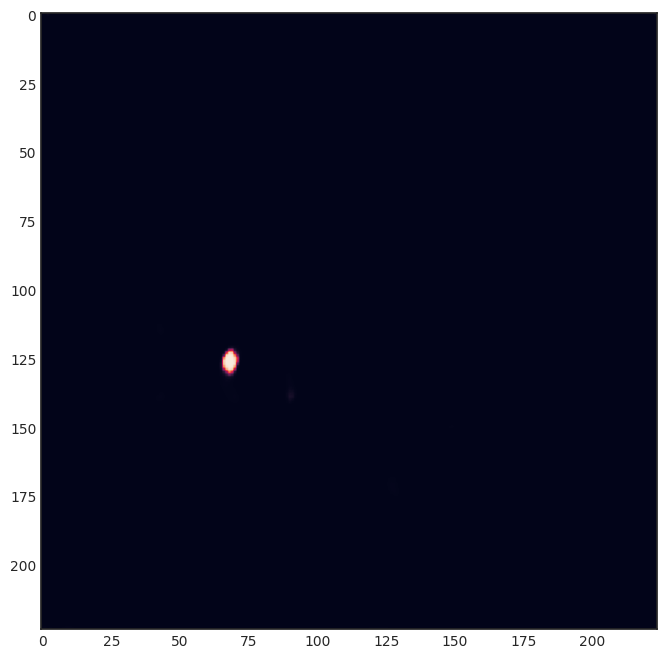

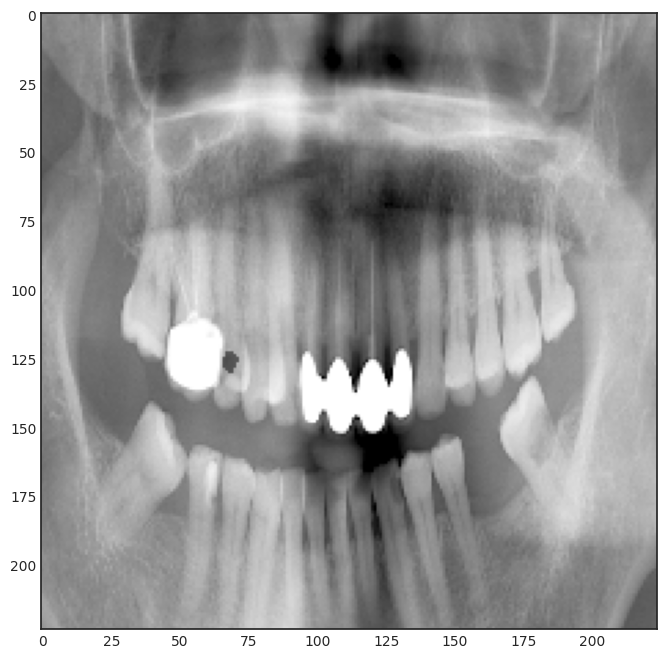

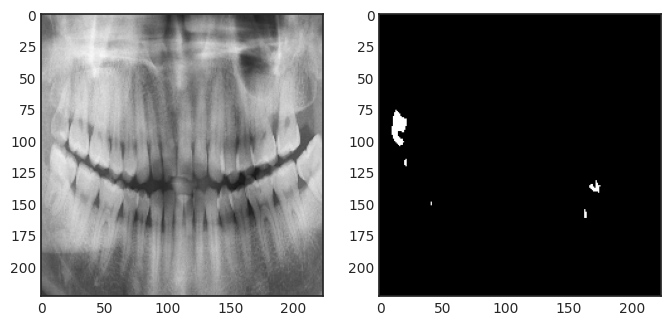

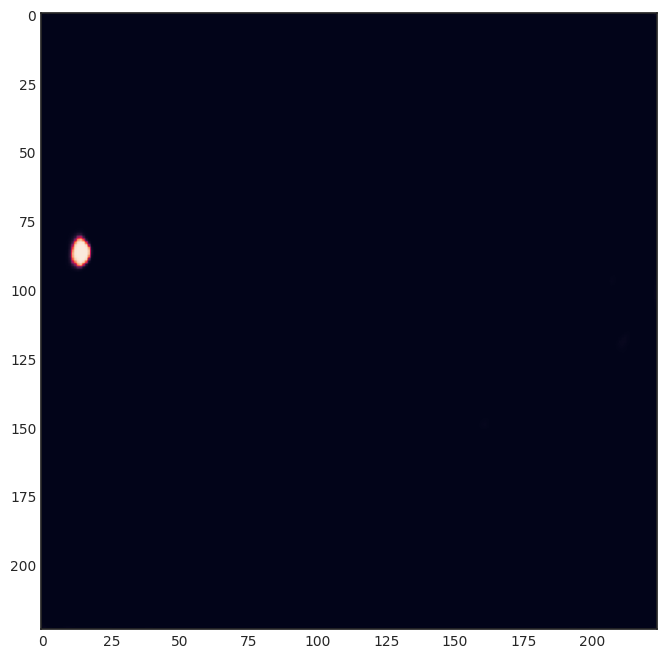

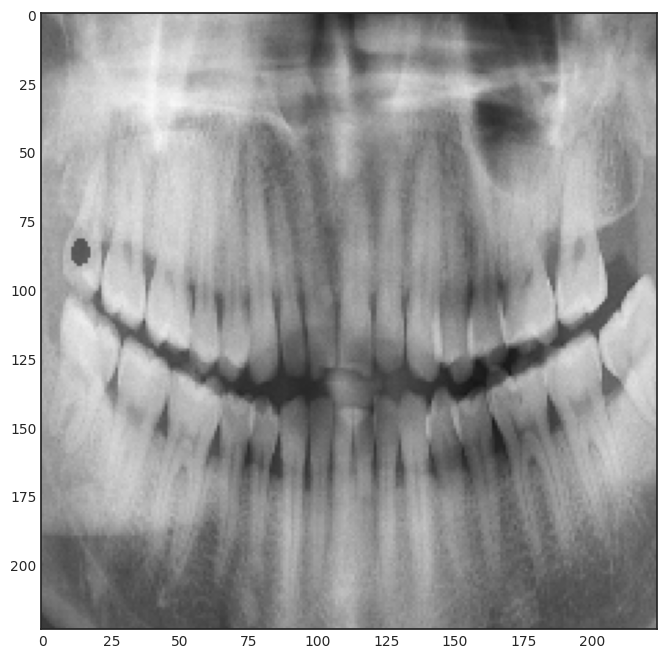

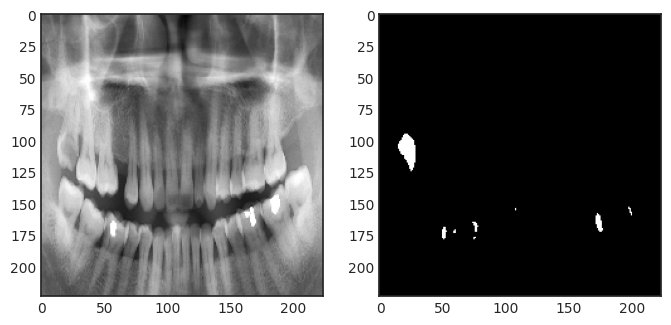

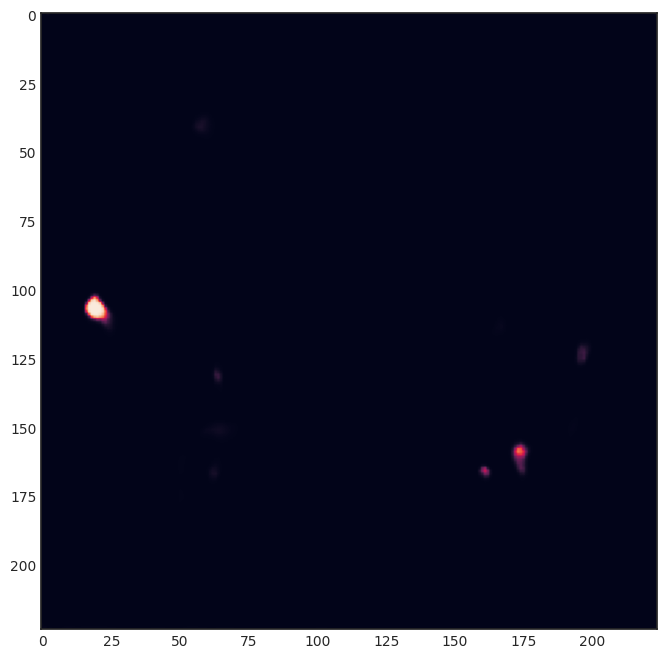

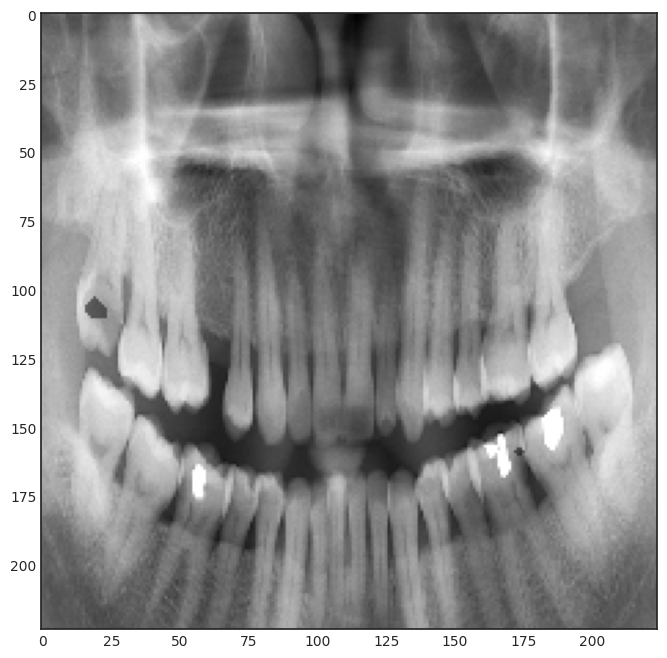

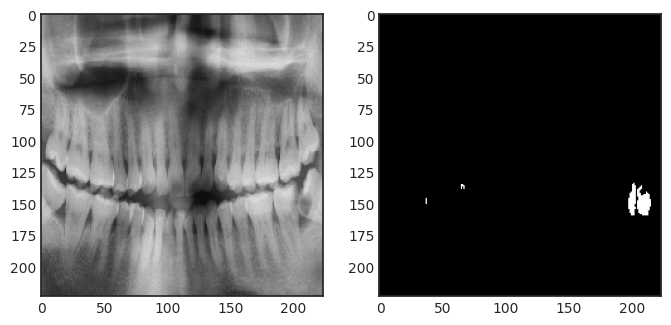

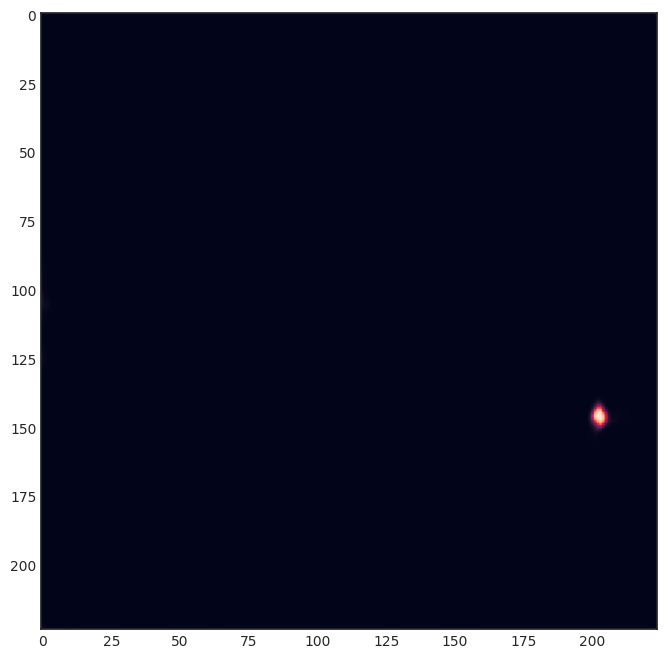

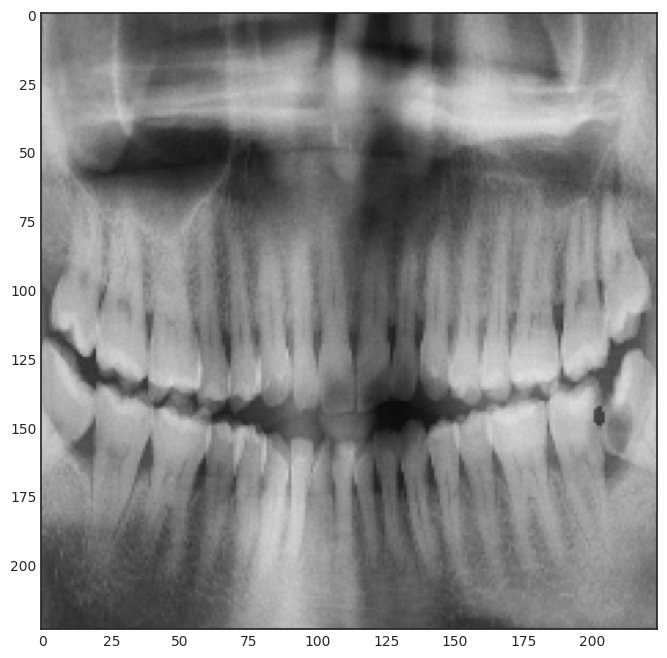

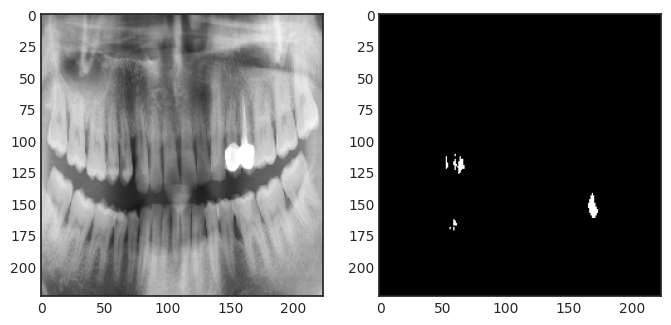

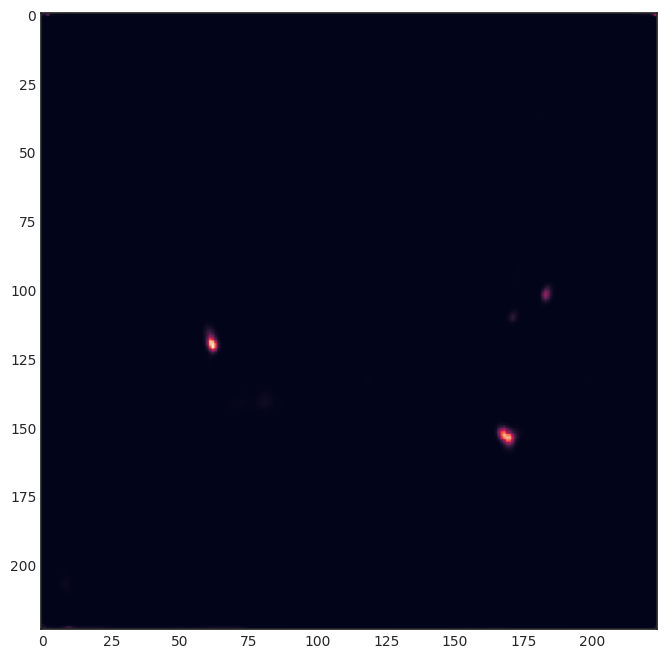

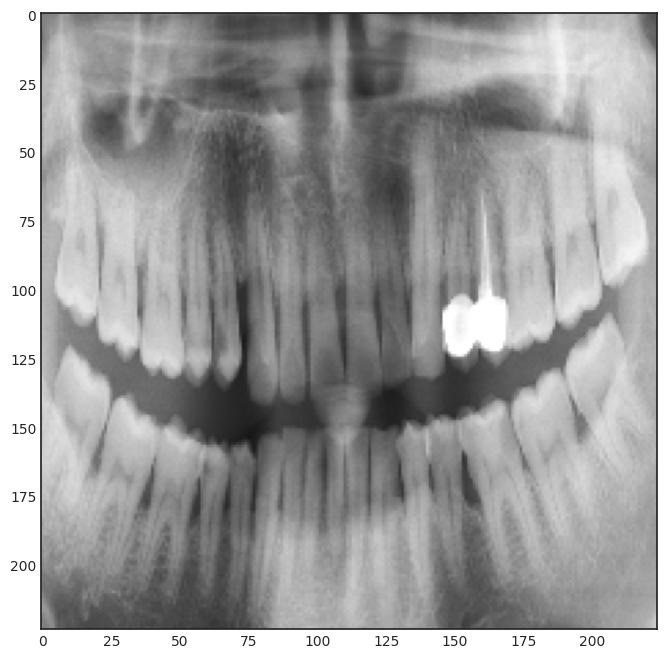

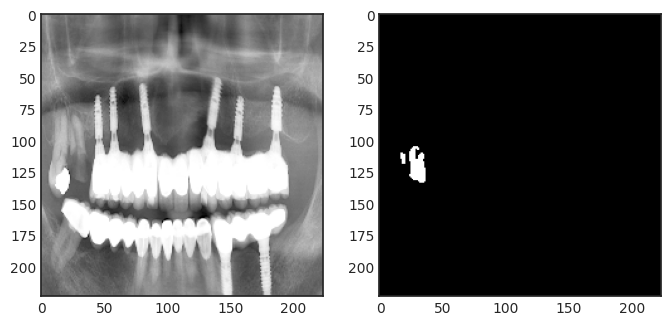

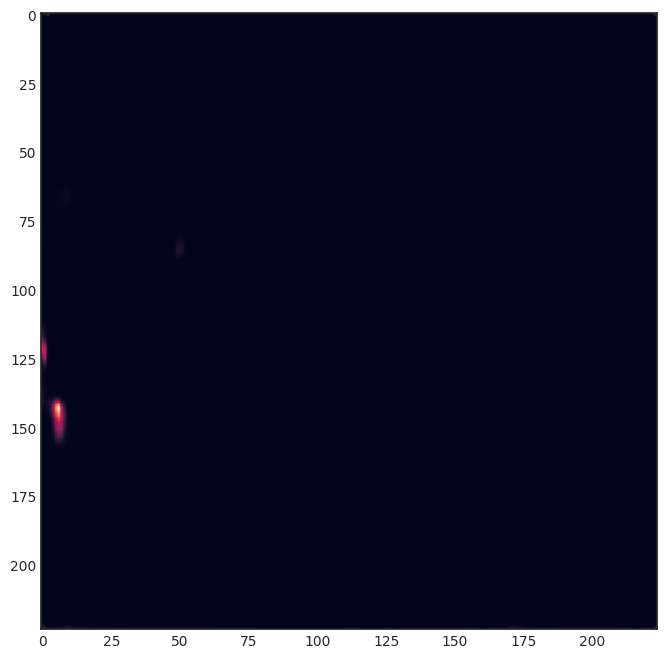

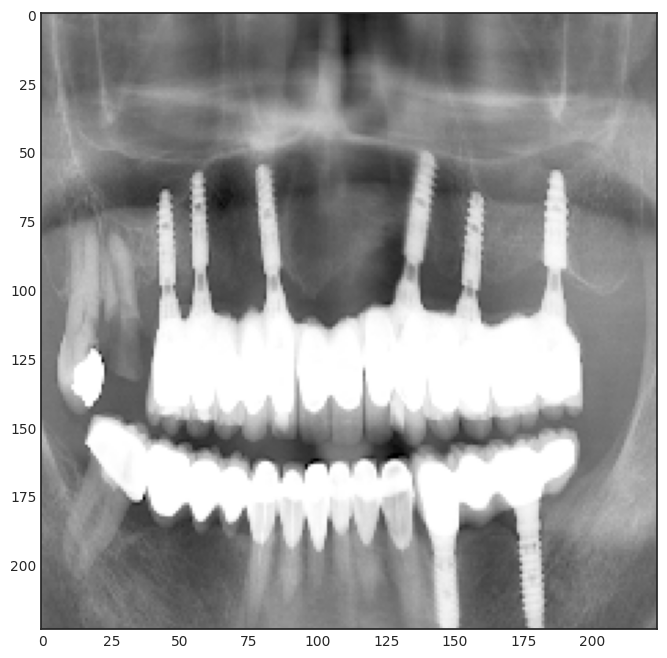

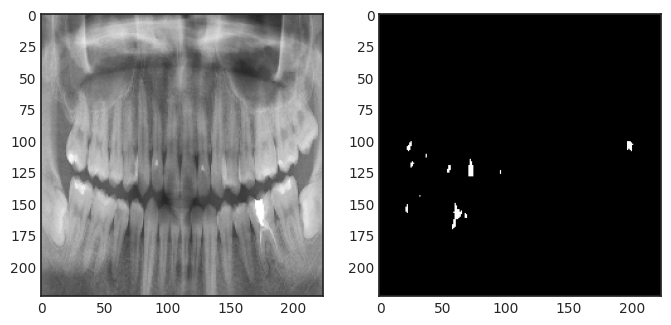

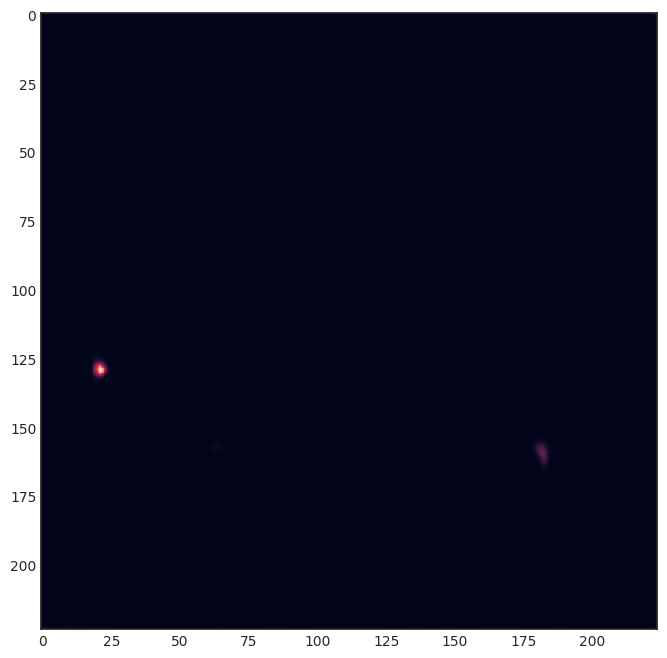

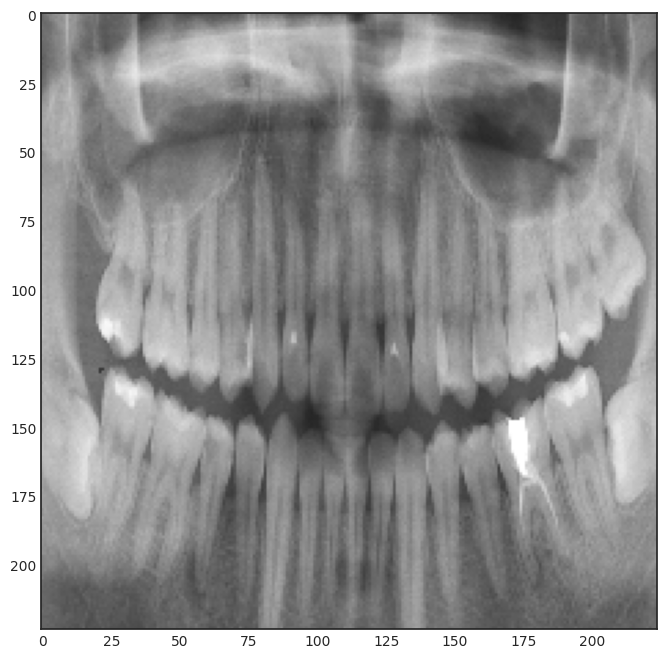

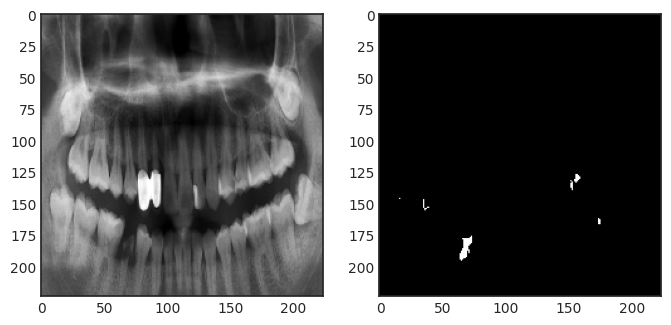

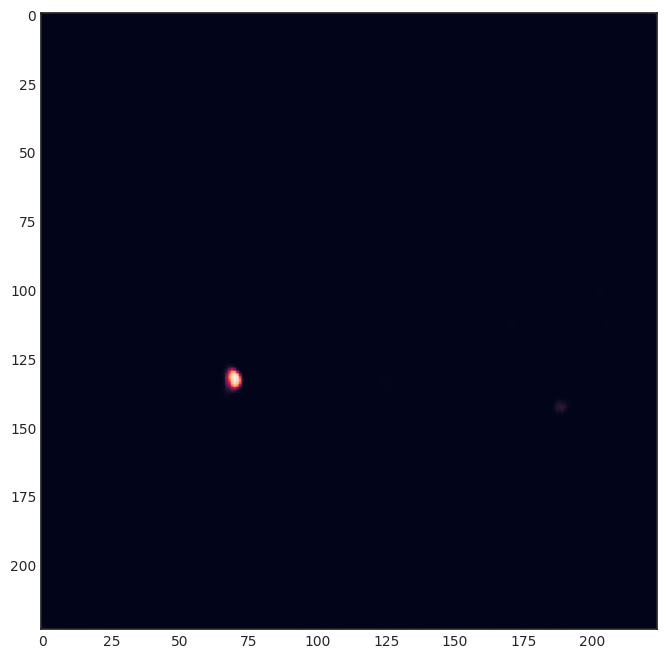

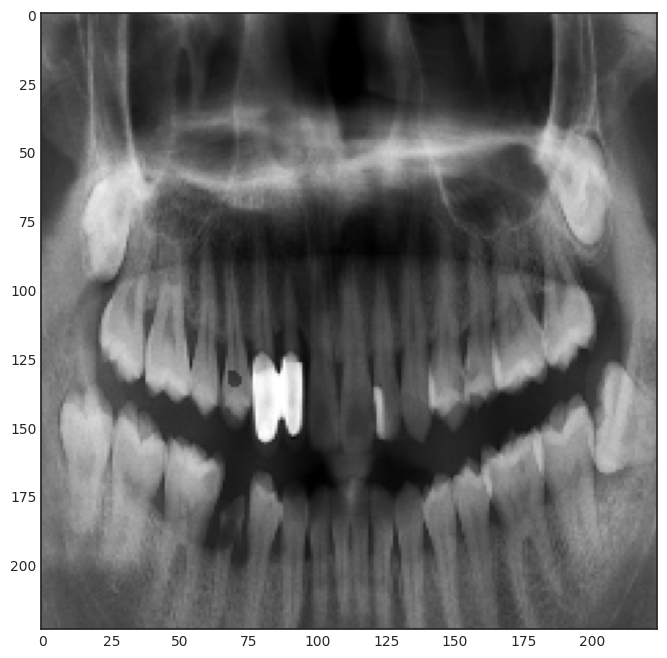

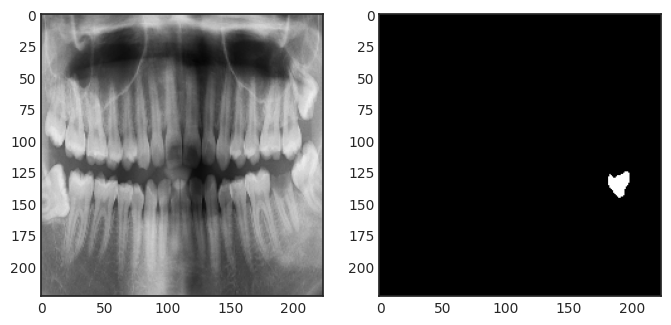

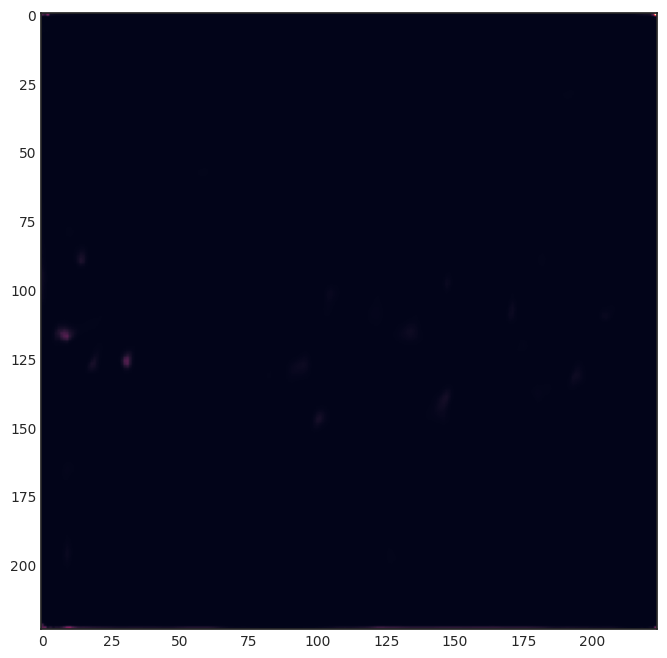

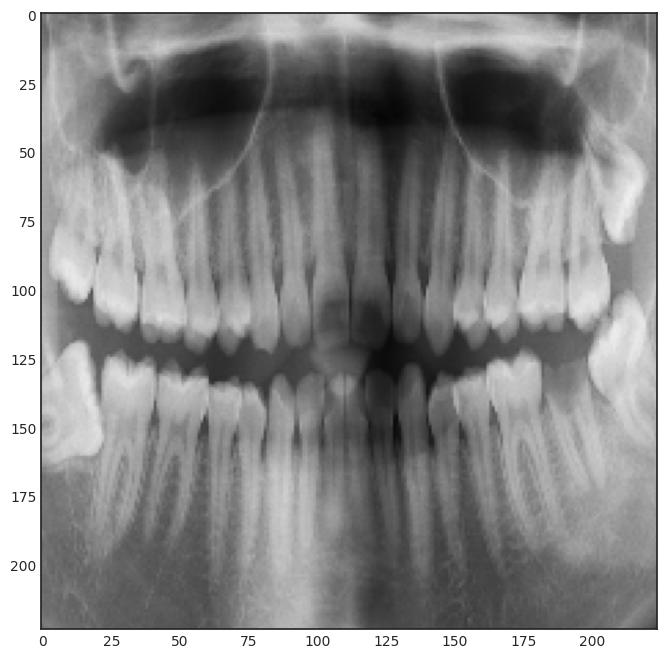

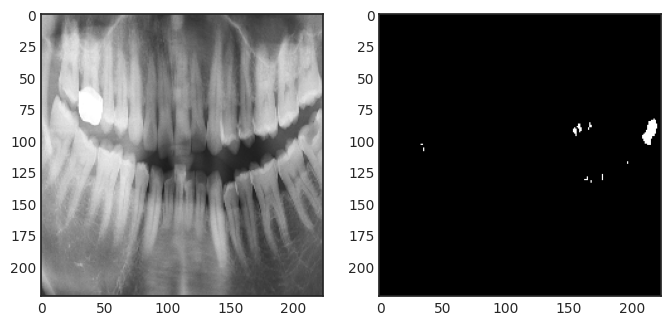

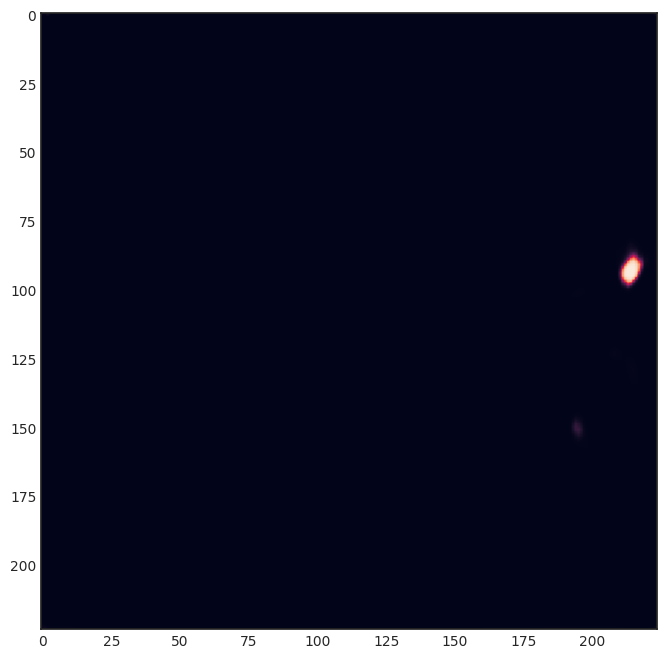

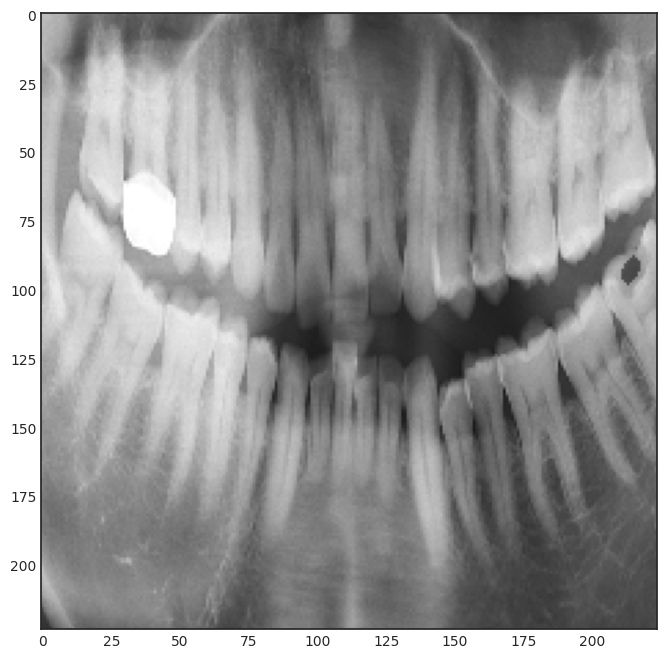

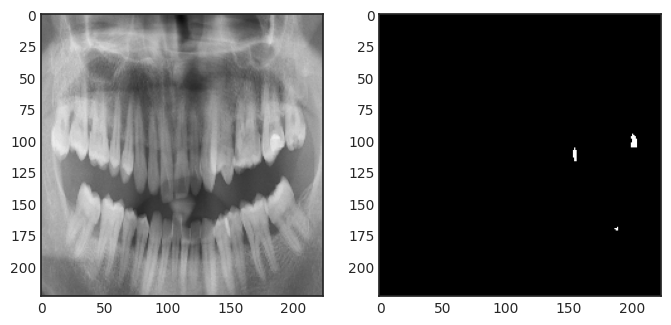

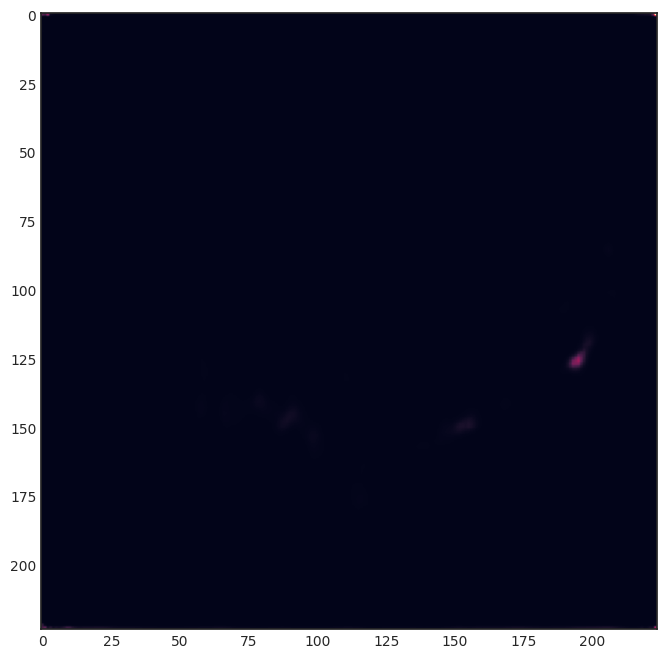

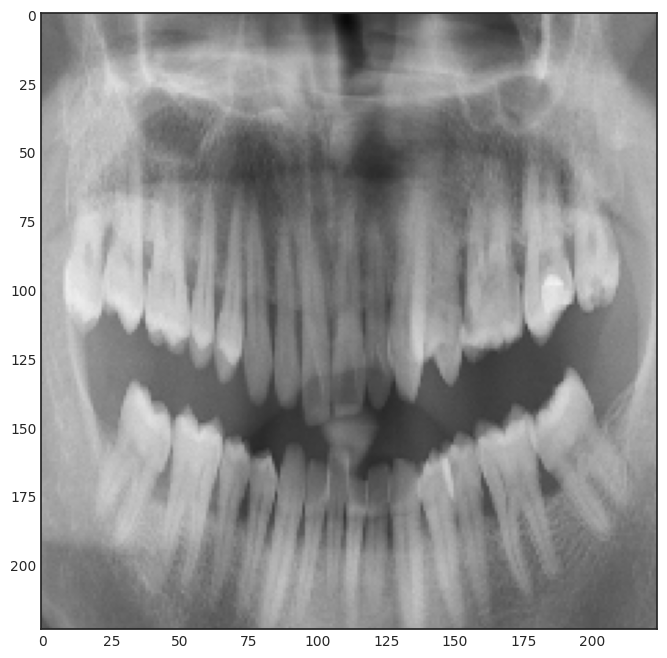

In [ ]:
test_image_path = val_files[5]
save_path = '/content/drive/MyDrive/TCC/resultados_resnet34_14_05'

for i in range(len(val_files)):

  test_image_path = val_files[i]
  image = '/content/drive/MyDrive/TCC/images_cut/' + test_image_path
  img = img_to_array(load_img(image, target_size=(img_w_target, img_h_target, 3))) / 255
  print(img.shape)

  mask = '/content/drive/MyDrive/TCC/labels_cut/' + test_image_path
  mask_img = img_to_array(load_img(mask, target_size=(img_w_target, img_h_target, 3)))

  print(test_image_path)

  plt.figure(figsize=(8,8))
  plt.subplot(121)
  plt.imshow(img)
  plt.subplot(122)
  plt.imshow(mask_img/255.)

  plt.savefig(save_path + '/' + str(i) + '.sample_mask.png')

  plt.figure(figsize=(8,8))

  predicted_mask = make_prediction(model,image,(img_w_target, img_h_target, 3))[0]
  plt.imshow(predicted_mask)
  plt.savefig(save_path + '/' + str(i) + '.predicted_mask.png')

  plt.figure(figsize=(8,8))

  plt.imshow(overlay_mask(img, predicted_mask.squeeze(),color=(255, 0, 0), alpha=0.5))

  plt.savefig(save_path + '/' + str(i) + '.overlay_mask.png')
